- example RAG file search
- feed examples to vision model 

not yet
- whole channel support
- learning from human feedback (remembers lessons learned)

In [ ]:
import pandas as pd
from dataset import MayoDataset

dataset = MayoDataset(base_dir="C:\\Users\\yuans\\Desktop\\Mayo_dataset\\DATASET_MAYO")

dataset.print_columns()

155182
Index(['index', 'anatomy', 'category_id', 'channel', 'electrode_type',
       'institution', 'patient_id', 'reviewer_id', 'segment_id', 'soz',
       'category_name'],
      dtype='object')
[1 3 2 0]
['noise' 'physiology' 'pathology' 'powerline_60hz']
155182


[ 0  2  3  4  5  6  9 16 17 18 19 20 21 23]

Processing: x024770 (noise)
Raw signal - Min: -4.21, Max: 1.51, Std: 1.00


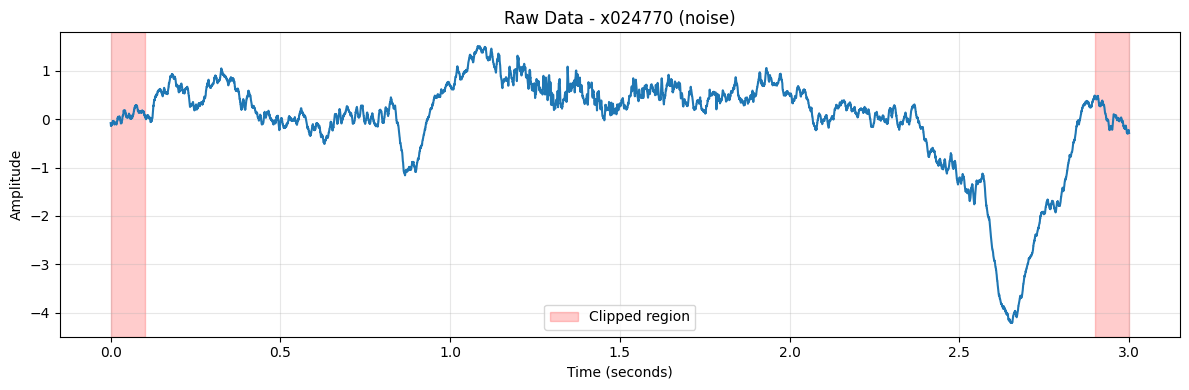


PDM Statistics (after clipping):
  Shape: (10, 10000)
  Time range: 0.50s to 2.50s
  Min: 0.001767, Max: 0.466229, Mean: 0.077343
    0-  4 Hz: mean=0.202126, max=0.349834
    4-  8 Hz: mean=0.179941, max=0.466229
    8- 13 Hz: mean=0.096431, max=0.254330
   13- 30 Hz: mean=0.087384, max=0.202192
   30- 55 Hz: mean=0.068200, max=0.192074
   57- 63 Hz: mean=0.029916, max=0.062231
   65- 80 Hz: mean=0.031536, max=0.081208
   80-150 Hz: mean=0.038327, max=0.177083
  150-250 Hz: mean=0.025155, max=0.135683
  250-500 Hz: mean=0.014414, max=0.099701

PDM Statistics (absolute values):
  Global - Min: 0.001767, Max: 0.466229, Mean: 0.077343
    0-  4 Hz: mean=0.202126, max=0.349834
    4-  8 Hz: mean=0.179941, max=0.466229
    8- 13 Hz: mean=0.096431, max=0.254330
   13- 30 Hz: mean=0.087384, max=0.202192
   30- 55 Hz: mean=0.068200, max=0.192074
   57- 63 Hz: mean=0.029916, max=0.062231
   65- 80 Hz: mean=0.031536, max=0.081208
   80-150 Hz: mean=0.038327, max=0.177083
  150-250 Hz: mean=0.0

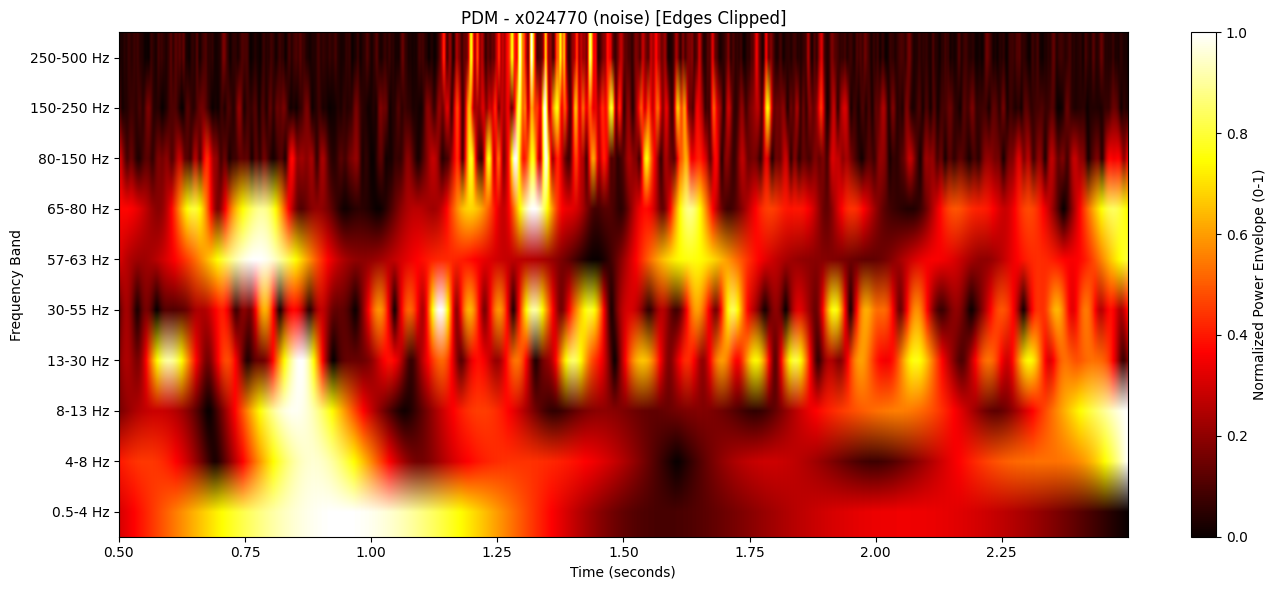

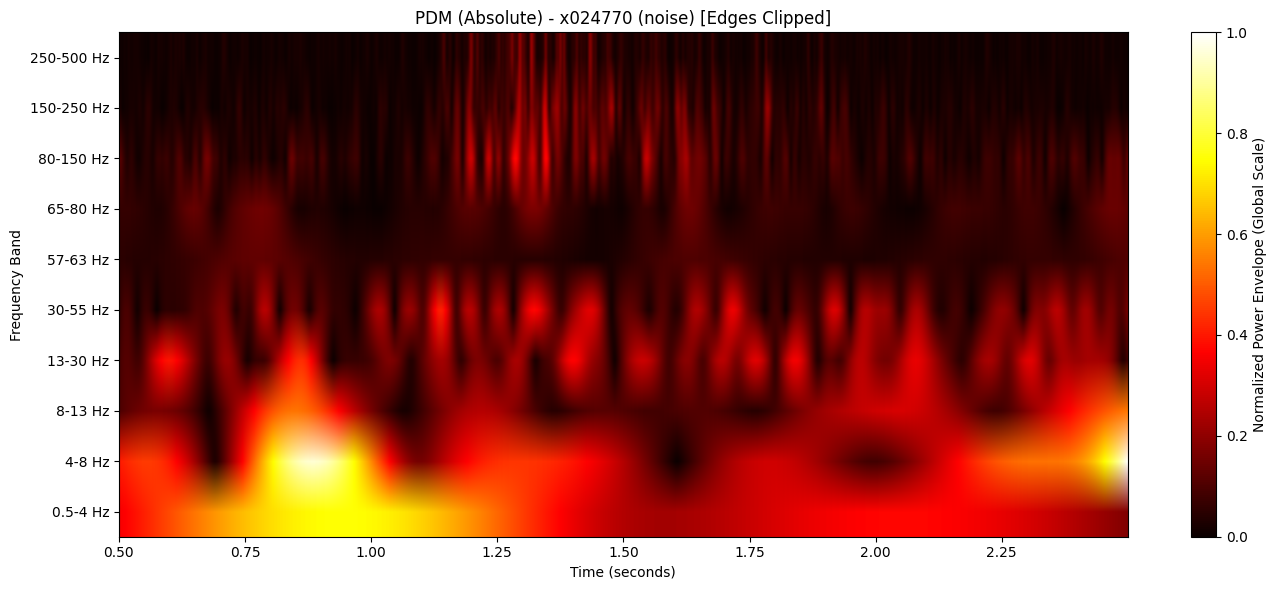

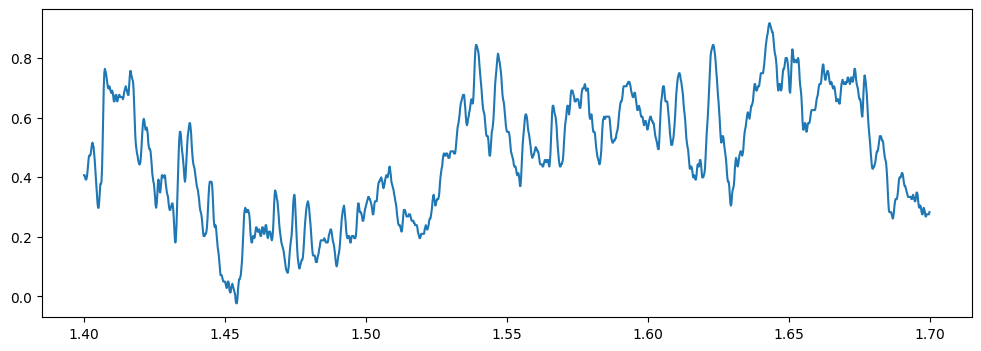

In [9]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import hilbert, butter, sosfiltfilt
from scipy.ndimage import gaussian_filter1d

def compute_pdm_fixed(signal, fs, freq_bands, clip_seconds=0.5):
    """
    Compute Power Distribution Matrix with edge clipping
    
    Parameters:
    - clip_seconds: How many seconds to clip from each edge (default 0.5s)
    """
    n_samples = len(signal)
    n_bands = len(freq_bands)
    time = np.arange(n_samples) / fs
    
    # Calculate samples to clip
    clip_samples = int(clip_seconds * fs)
    
    pdm = np.zeros((n_bands, n_samples))
    
    for i, (low_freq, high_freq) in enumerate(freq_bands):
        nyquist = fs / 2
        low = max(low_freq / nyquist, 0.001)
        high = min(high_freq / nyquist, 0.999)
        
        if low >= high:
            continue
        
        # Use SOS for better numerical stability
        sos = butter(4, [low, high], btype='band', output='sos')
        filtered_signal = sosfiltfilt(sos, signal)
        
        # Compute envelope using Hilbert transform
        analytical_signal = hilbert(filtered_signal)
        envelope = np.abs(analytical_signal)
        
        # Smooth the envelope slightly
        envelope_smooth = gaussian_filter1d(envelope, sigma=10)
        
        pdm[i, :] = envelope_smooth
    
    # Clip edges
    if clip_samples > 0:
        pdm_clipped = pdm[:, clip_samples:-clip_samples]
        time_clipped = time[clip_samples:-clip_samples]
    else:
        pdm_clipped = pdm
        time_clipped = time
    
    return pdm_clipped, time_clipped

def plot_pdm_absolute(pdm, time, freq_bands, title="Power Distribution Matrix"):
    """Plot PDM with global normalization to show relative power"""
    
    print(f"\nPDM Statistics (absolute values):")
    print(f"  Global - Min: {pdm.min():.6f}, Max: {pdm.max():.6f}, Mean: {pdm.mean():.6f}")
    
    for i, (low, high) in enumerate(freq_bands):
        print(f"  {low:3.0f}-{high:3.0f} Hz: mean={pdm[i,:].mean():.6f}, max={pdm[i,:].max():.6f}")
    
    plt.figure(figsize=(14, 6))
    
    freq_labels = [f"{low}-{high} Hz" for low, high in freq_bands]
    
    global_min = pdm.min()
    global_max = pdm.max()
    pdm_normalized = (pdm - global_min) / (global_max - global_min)
    
    plt.imshow(pdm_normalized, aspect='auto', cmap='hot', interpolation='bilinear',
               extent=[time[0], time[-1], 0, len(freq_bands)], origin='lower')  # Added origin='lower'
    plt.colorbar(label='Normalized Power Envelope (Global Scale)')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Frequency Band')
    plt.yticks(np.arange(len(freq_bands)) + 0.5, freq_labels)
    plt.title(title)
    plt.tight_layout()

def plot_pdm_normalized(pdm, time, freq_bands, title="Power Distribution Matrix"):
    """Plot PDM with robust visualization"""
    
    # Print statistics
    print(f"\nPDM Statistics (after clipping):")
    print(f"  Shape: {pdm.shape}")
    print(f"  Time range: {time[0]:.2f}s to {time[-1]:.2f}s")
    print(f"  Min: {pdm.min():.6f}, Max: {pdm.max():.6f}, Mean: {pdm.mean():.6f}")
    
    # Check each frequency band
    for i, (low, high) in enumerate(freq_bands):
        print(f"  {low:3.0f}-{high:3.0f} Hz: mean={pdm[i,:].mean():.6f}, max={pdm[i,:].max():.6f}")
    
    plt.figure(figsize=(14, 6))
    
    freq_labels = [f"{low}-{high} Hz" for low, high in freq_bands]
    
    # Normalize each frequency band independently
    pdm_normalized = np.zeros_like(pdm)
    for i in range(pdm.shape[0]):
        row_min = pdm[i, :].min()
        row_max = pdm[i, :].max()
        if row_max > row_min:
            pdm_normalized[i, :] = (pdm[i, :] - row_min) / (row_max - row_min)
    
    plt.imshow(pdm_normalized, aspect='auto', cmap='hot', interpolation='bilinear',
               extent=[time[0], time[-1], 0, len(freq_bands)], origin='lower')  # Added origin='lower'
    plt.colorbar(label='Normalized Power Envelope (0-1)')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Frequency Band')
    plt.yticks(np.arange(len(freq_bands)) + 0.5, freq_labels)
    plt.title(title)
    plt.tight_layout()

# Frequency bands with specific 60Hz detection
freq_bands = [
    (0.5, 4),      # Delta
    (4, 8),        # Theta
    (8, 13),       # Alpha
    (13, 30),      # Beta
    (30, 55),      # Low Gamma
    (57, 63),      # **60 Hz POWERLINE**
    (65, 80),      # Mid Gamma
    (80, 150),     # High Gamma
    (150, 250),    # Ripple
    (250, 500),    # Fast Ripple
]

# Test on powerline data
print(df_noise["patient_id"].unique())
test_df = df_noise[df_noise["patient_id"]==5].head(1)
# test_df = df[df["segment_id"]=="x030605"]

for idx, segment_df in test_df.iterrows():
    raw_path = "C:\\Users\\yuans\\Desktop\\Mayo_dataset\\DATASET_MAYO\\" + segment_df["segment_id"] + ".mat"
    mat = scipy.io.loadmat(raw_path)
    #turn raw data into np array
    raw_data = np.array(mat["data"]).flatten()
    
    print(f"\n{'='*60}")
    print(f"Processing: {segment_df['segment_id']} ({segment_df['category_name']})")
    print(f"Raw signal - Min: {raw_data.min():.2f}, Max: {raw_data.max():.2f}, Std: {raw_data.std():.2f}")
    
    # Plot raw data with clipping regions indicated
    plt.figure(figsize=(12, 4))
    time_full = np.arange(len(raw_data)) / 5000
    plt.plot(time_full, raw_data)
    
    # Show clipped regions
    clip_time = 0.1
    plt.axvspan(0, clip_time, alpha=0.2, color='red', label='Clipped region')
    plt.axvspan(time_full[-1] - clip_time, time_full[-1], alpha=0.2, color='red')
    
    plt.title(f"Raw Data - {segment_df['segment_id']} ({segment_df['category_name']})")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Compute and plot PDM with clipping
    pdm, pdm_time = compute_pdm_fixed(raw_data, fs=5000, freq_bands=freq_bands, clip_seconds=0.5)
    plot_pdm_normalized(pdm, pdm_time, freq_bands, 
                   title=f"PDM - {segment_df['segment_id']} ({segment_df['category_name']}) [Edges Clipped]")
    plot_pdm_absolute(pdm, pdm_time, freq_bands, 
                   title=f"PDM (Absolute) - {segment_df['segment_id']} ({segment_df['category_name']}) [Edges Clipped]")
    plt.show()

    metadata = {
        "sampling_rate": 5000,
        # "category_name": segment_df["category_name"],
        "anatomy": segment_df["anatomy"],
        "channel": segment_df["channel"],
        "electrode_type": segment_df["electrode_type"],
        "soz": segment_df["soz"],
        "suggestions": """for detecting muscle noise, the expert would look at the raw waveform for Look for segments where the 
        signal shows high-frequency, dense, jagged oscillations that make the trace appear thick, fuzzy, or 'hairy' as if 
        many rapid up-and-down movements are superimposed on the underlying signal. the expert would also examine the
        power distribution matrix (PDM) with per-band normalization mode. In the time-frequency representation, muscle artifacts appear as vertical stripes or 
        bands of bright, high-intensity power spanning broad frequency ranges, especially above 150 Hz. Look for sustained 
        periods where you see dense, continuous high-frequency activity creating a 'curtain-like' pattern of vertical lines, 
        rather than the discrete, frequency-specific patterns typical of neural oscillations. These contaminated segments show 
        elevated power across multiple high-frequency bands simultaneously.
        for detecting pathology, the expert would look at the power distribution matrix (PDM) with global normalization mode.
        if there exist a single sharp vertical stripe of high power in a narrow frequency band. which is different from muscle noise which could consist
        of multiple """,
        "context": """Each data segment is described by clinical useful features: classification category 
        (power line interference; high frequency noise; pathological activity; physiological activity), 
        seizure onset zone (True, False), anatomical location, electrode type, reviewer identification number, patient number.
        In general, datasets contain data clips from four groups of distinctive events: 
        powerline noise (in our case 50 Hz or 60 Hz depending on power line frequency at clinic’s location); 
        muscle and machine artifacts (artifactual signals (like muscle artifacts) caused by patient movement or other physiological sources commonly 
        share features with pathological signals, e.g. power in band 200–600 Hz.); 
        physiological iEEG activity in different behavioral states of subject (sleep/wake/wake-relax); 
        pathophysiological activity we are targeting identification of signal graphoelements and 
        thus defining pathological signal group as signals with epileptiform graphoelements e.g.: HFOs and spikes or epileptiform discharges.
        Mayo Clinic data were recorded during the first night after electrode implantation and consisted of two-hour long iEEG recordings. 
        The data were collected between 1 AM and 3 AM from 25 patients with DRE undergoing evaluation for epilepsy surgery. 
        The Neuralynx Cheetah system (Neuralynx Inc., Bozeman MT, USA) was used to acquire the data at sampling rate of 32 kHz with 
        hardware filter bandwidth of DC – 9 kHz. Similar to St’ Anne’s recordings, all data were filtered by an antialiasing filter, 
        but in this case with cutoff frequency of 1 kHz. The data was subsequently down-sampled to 5 kHz. 
        Patients were implanted with either depth electrodes or grids and strips, or the combination. 
        The depth electrodes used in the dataset were AD-Tech electrodes (AD-Tech Medical Instrument Corp., Racine, WI or PMT, Chahassen, MN, USA) 
        and consisted of 4 or 8 Platinum/Iridium contacts (2.3 mm long, 1 mm diameter, spaced 5 or 10 mm center-to-center). 
        AD-Tech subdural grids and strips electrodes had 4.0 mm diameter Platinum/Iridium discs (2.3 mm exposed) with 10 mm center-to-center distance.
        All data were reviewed in SignalPlant18, a free software tool for signal processing, inspection and annotation. 
        The dataset was annotated by 3 reviewers, where each recording was reviewed by single reviewer. 
        Each recording was visually reviewed in time domain alongside power distribution matrices (PDM) for manual artifact detection13. 
        The PDM method estimates the signal power envelope by data filtering in specific frequency bands, 
        and further computes the absolute value of the analytical signal (analytical signal is complex signal comprising original signal in the real domain 
        and its Hilbert transform in imaginary domain) to obtain the signal envelope. Visual inspection of the PDM allow for fast localization of high-power 
        events appearing across all channels and are likely to be artifacts. The signal regions with high power envelope were subsequently reviewed in the 
        time domain to classify signals into pathological/artifactual group. 
        If Pathology and powerline boise are booth detected, the segment is labeled as Pathology."""
    }

    #plot raw data from second 1.5 to 1.6
    plt.figure(figsize=(12, 4))
    start_time = 1.4
    end_time = 1.7
    start_sample = int(start_time * 5000)
    end_sample = int(end_time * 5000)
    time_zoom = np.arange(start_sample, end_sample) / 5000
    plt.plot(time_zoom, raw_data[start_sample:end_sample])

In [5]:
from agent import build_example_bank
bank = build_example_bank("./examples/examples.jsonl")

Computed embedding for example power_density_matrix_example_01
Computed embedding for example timeseries_example_01
Computed embedding for example power_density_matrix_example_02
Computed embedding for example timeseries_example_02
Computed embedding for example power_density_matrix_example_03
Computed embedding for example timeseries_example_03
Loaded 6 examples from ./examples/examples.jsonl


In [10]:
import json
import numpy as np
from agent import build_inspection_graph, InspectionState
import shutil


if __name__ == "__main__":
    # delete plots folder
    
    shutil.rmtree("./plots", ignore_errors=True)

    app = build_inspection_graph()

    init_state: InspectionState = {
        "goal": "determine which one of the four category (artifact, physiology, pathology, powerline noise)the segment is best described by.",
        "raw_data": raw_data,
        "metadata": metadata,
        "max_steps": 3,
        "step": 0,
        "example_bank": bank,
    }


    def safe_serialize(obj):
        """Convert nested objects (Pydantic models, ndarrays, etc.) into JSON-safe structures."""
        if hasattr(obj, "model_dump"):
            return safe_serialize(obj.model_dump())
        if isinstance(obj, np.ndarray):
            return f"np.ndarray(shape={obj.shape})"
        if isinstance(obj, list):
            if len(obj) > 50:   # truncate long lists to avoid notebook spam
                return f"[...{len(obj)} items...]"
            return [safe_serialize(v) for v in obj]
        if isinstance(obj, dict):
            return {k: safe_serialize(v) for k, v in obj.items()}
        return obj


    print("=== DEBUG STREAM OF PIPELINE ===")


    for event in app.stream(init_state):
        node_name = event.get("node", "UNKNOWN")
        print(f"\n--- NODE: {node_name} ---")
        print(json.dumps(safe_serialize(event), indent=2))

=== DEBUG STREAM OF PIPELINE ===

--- NODE: UNKNOWN ---
{
  "setup": {
    "goal_schema": {
      "schema_name": "segment_classification",
      "goal": "determine which one of the four category (artifact, physiology, pathology, powerline noise) the segment is best described by.",
      "description": "Classify a neural data segment into one of four categories: artifact, physiology, pathology, or powerline noise based on visual and spectral analysis.",
      "fields": [
        {
          "name": "category",
          "type": "enum",
          "description": "The classification category of the segment.",
          "required": true,
          "allowed_values": [
            "artifact",
            "physiology",
            "pathology",
            "powerline noise"
          ]
        },
        {
          "name": "dominant_features",
          "type": "string",
          "description": "Description of the dominant features observed in the segment that led to its classification.",
   

### Testing at Scale


Processing 1/10: x105178
Ground truth: powerline_60hz


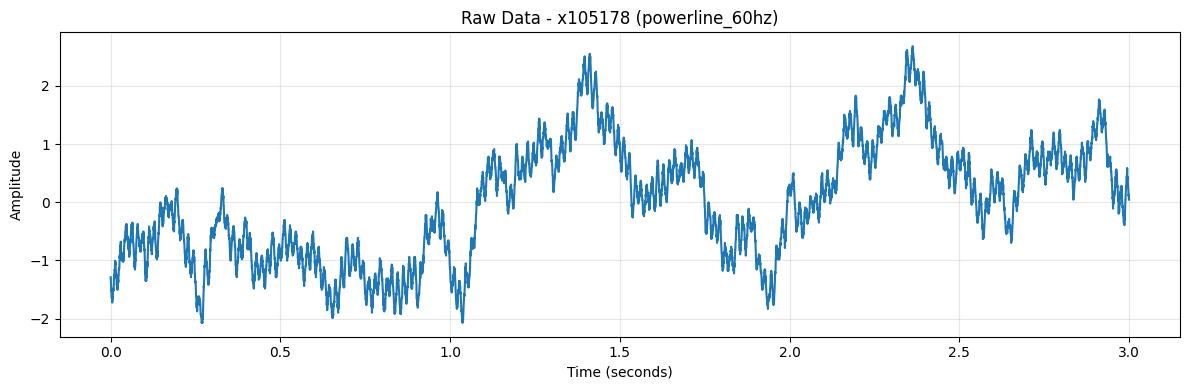


PDM Statistics (after clipping):
  Shape: (10, 10000)
  Time range: 0.50s to 2.50s
  Min: 0.001543, Max: 0.781342, Mean: 0.128752
    0-  4 Hz: mean=0.247694, max=0.486192
    4-  8 Hz: mean=0.371001, max=0.781342
    8- 13 Hz: mean=0.163116, max=0.309089
   13- 30 Hz: mean=0.121318, max=0.282646
   30- 55 Hz: mean=0.078996, max=0.183325
   57- 63 Hz: mean=0.211269, max=0.249501
   65- 80 Hz: mean=0.024072, max=0.059784
   80-150 Hz: mean=0.026330, max=0.098433
  150-250 Hz: mean=0.019747, max=0.047075
  250-500 Hz: mean=0.023977, max=0.055787


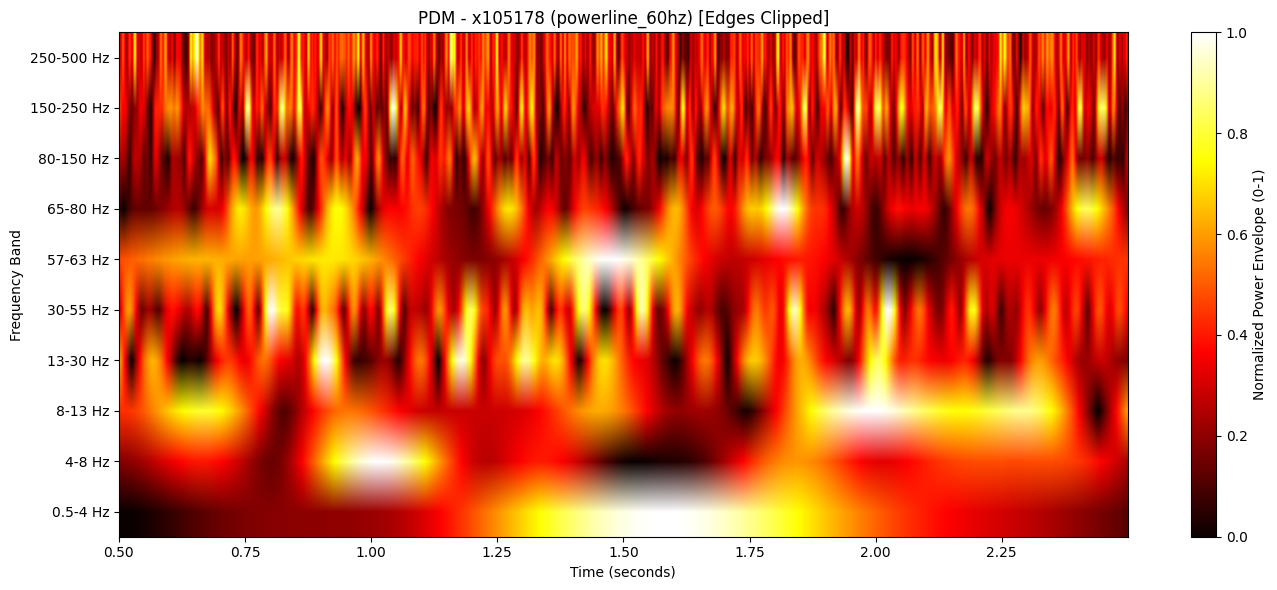

Executing pipeline...

DEBUG - Error extracting result:
  Error: 'category'
  Result keys: dict_keys(['goal', 'raw_data', 'metadata', 'max_steps', 'example_bank', 'goal_schema', 'interpreter_prompts', 'step', 'done', 'planner_output', 'execution_output', 'image_interp', 'execution_history', 'reasoning_history', 'retrieved_examples', 'goal_output'])
  Goal output type: <class 'agent.GoalOutput'>
  Goal output: schema_name='segment_classification' result={'classification_category': 'powerline noise', 'dominant_frequency': 60, 'high_power_bands': [60, 120, 180, 240, 300, 360, 420, 480, 540, 600, 660, 720, 780, 840, 900, 960], 'temporal_features': 'The time series appears less noisy, indicating a consistent pattern without significant temporal artifacts.', 'summary': 'The segment is best classified as powerline noise due to the presence of dominant frequencies at regular intervals, characteristic of harmonics of a 60 Hz powerline noise.'} rationale='The classification is based on the power

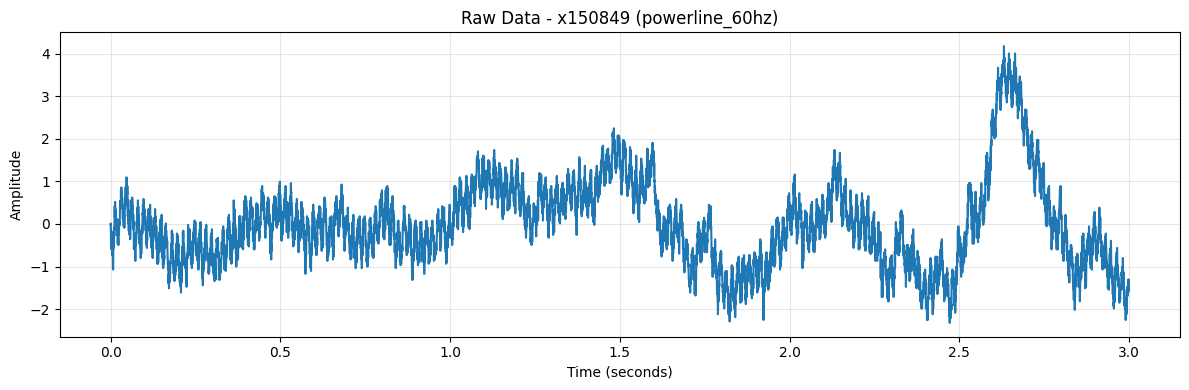


PDM Statistics (after clipping):
  Shape: (10, 10000)
  Time range: 0.50s to 2.50s
  Min: 0.002056, Max: 0.482365, Mean: 0.151005
    0-  4 Hz: mean=0.201338, max=0.331384
    4-  8 Hz: mean=0.219036, max=0.448716
    8- 13 Hz: mean=0.206917, max=0.460617
   13- 30 Hz: mean=0.180159, max=0.482365
   30- 55 Hz: mean=0.078397, max=0.292616
   57- 63 Hz: mean=0.381701, max=0.412418
   65- 80 Hz: mean=0.036147, max=0.091309
   80-150 Hz: mean=0.055648, max=0.160918
  150-250 Hz: mean=0.057054, max=0.171824
  250-500 Hz: mean=0.093651, max=0.212412


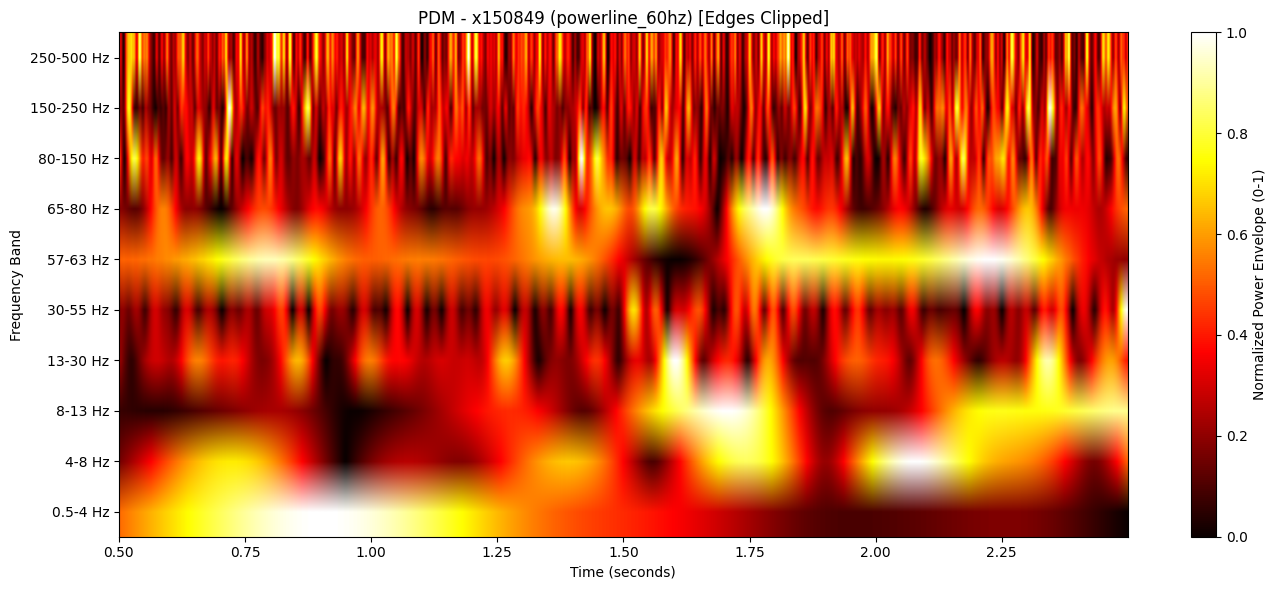

Executing pipeline...
Agent result: powerline noise

Processing 3/10: x097017
Ground truth: powerline_60hz


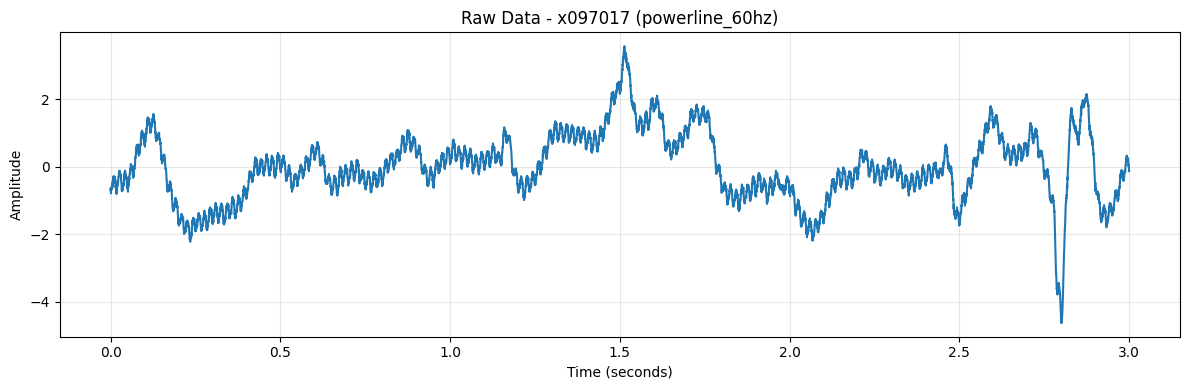


PDM Statistics (after clipping):
  Shape: (10, 10000)
  Time range: 0.50s to 2.50s
  Min: 0.000792, Max: 0.877417, Mean: 0.130697
    0-  4 Hz: mean=0.175528, max=0.351135
    4-  8 Hz: mean=0.468044, max=0.877417
    8- 13 Hz: mean=0.204022, max=0.612194
   13- 30 Hz: mean=0.117304, max=0.519443
   30- 55 Hz: mean=0.044388, max=0.163190
   57- 63 Hz: mean=0.203805, max=0.216480
   65- 80 Hz: mean=0.014708, max=0.044212
   80-150 Hz: mean=0.023686, max=0.051519
  150-250 Hz: mean=0.030284, max=0.055094
  250-500 Hz: mean=0.025197, max=0.053198


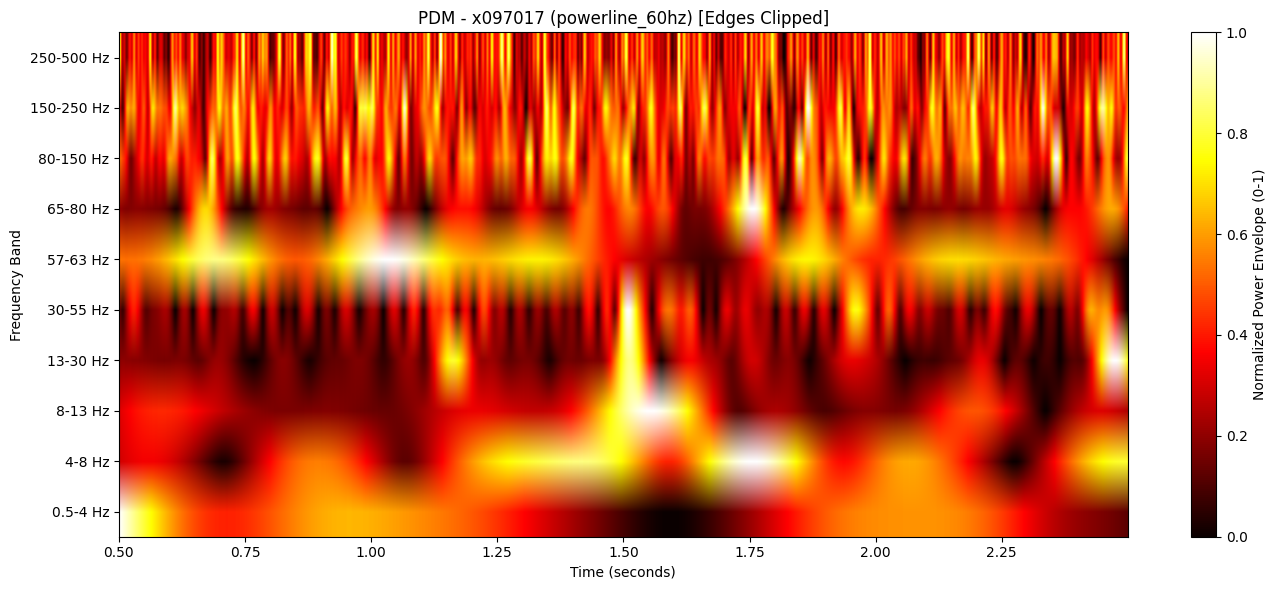

Executing pipeline...
Agent result: pathology

Processing 4/10: x082282
Ground truth: powerline_60hz


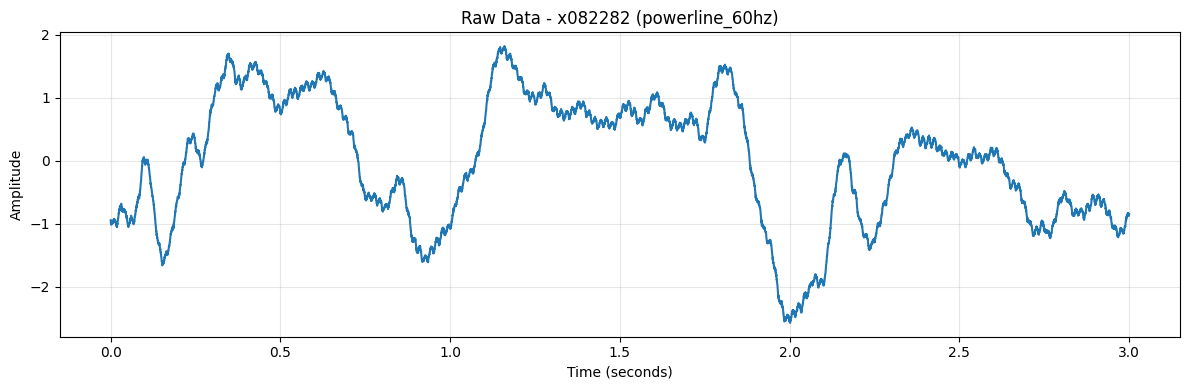


PDM Statistics (after clipping):
  Shape: (10, 10000)
  Time range: 0.50s to 2.50s
  Min: 0.000294, Max: 0.737277, Mean: 0.094559
    0-  4 Hz: mean=0.410774, max=0.737277
    4-  8 Hz: mean=0.257807, max=0.674822
    8- 13 Hz: mean=0.121506, max=0.267159
   13- 30 Hz: mean=0.055680, max=0.143726
   30- 55 Hz: mean=0.016497, max=0.074916
   57- 63 Hz: mean=0.055327, max=0.059885
   65- 80 Hz: mean=0.004241, max=0.024149
   80-150 Hz: mean=0.007827, max=0.017270
  150-250 Hz: mean=0.008380, max=0.015514
  250-500 Hz: mean=0.007551, max=0.015549


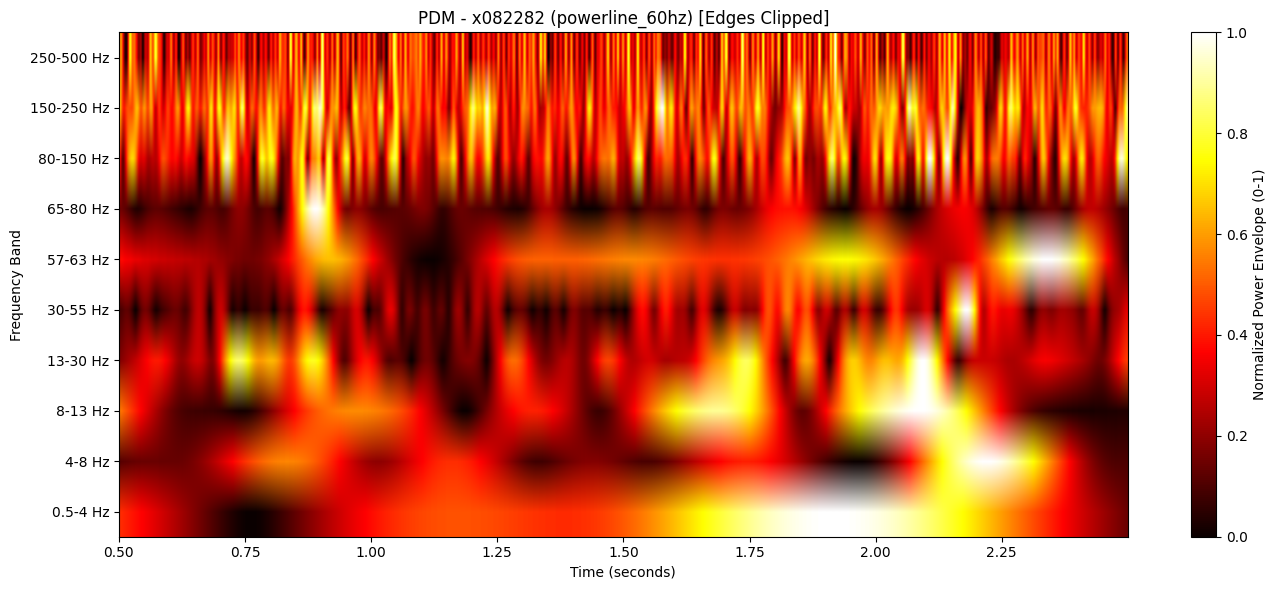

Executing pipeline...
Agent result: physiology

Processing 5/10: x109624
Ground truth: powerline_60hz


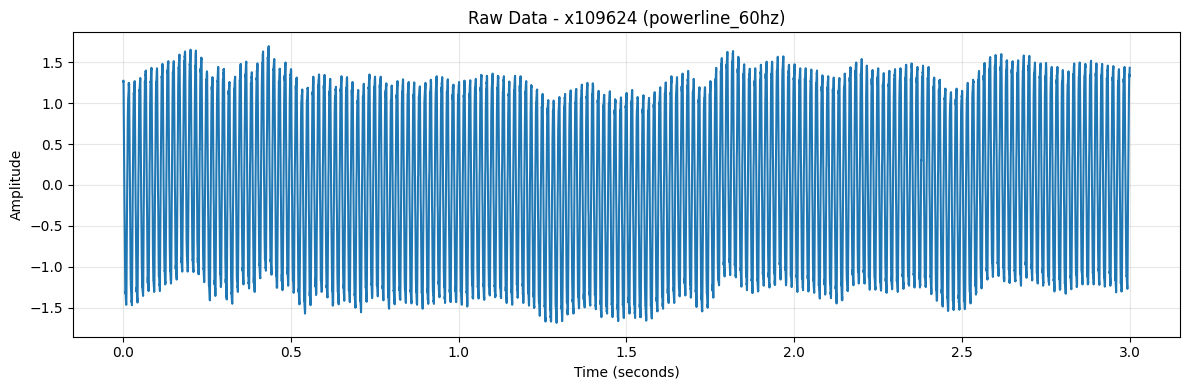


PDM Statistics (after clipping):
  Shape: (10, 10000)
  Time range: 0.50s to 2.50s
  Min: 0.000895, Max: 1.407606, Mean: 0.193109
    0-  4 Hz: mean=0.039406, max=0.125604
    4-  8 Hz: mean=0.072772, max=0.157939
    8- 13 Hz: mean=0.029908, max=0.074834
   13- 30 Hz: mean=0.021643, max=0.063520
   30- 55 Hz: mean=0.156607, max=0.199127
   57- 63 Hz: mean=1.389531, max=1.407606
   65- 80 Hz: mean=0.022122, max=0.143757
   80-150 Hz: mean=0.011837, max=0.144777
  150-250 Hz: mean=0.096283, max=0.113768
  250-500 Hz: mean=0.090980, max=0.117339


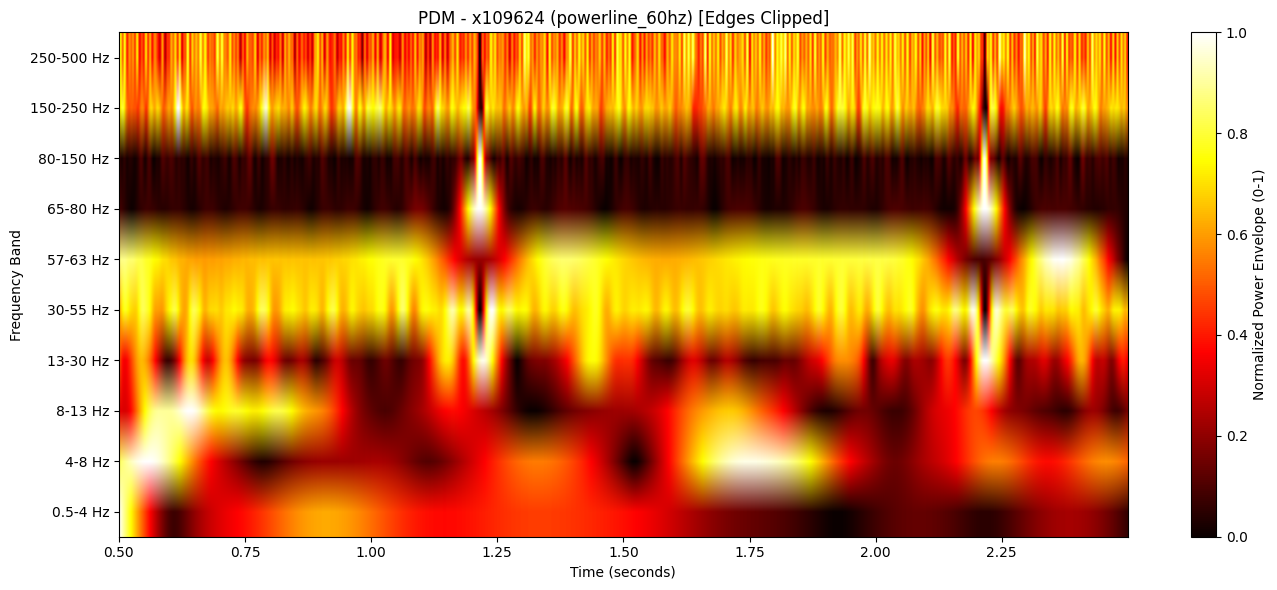

Executing pipeline...
Agent result: powerline noise

Processing 6/10: x117385
Ground truth: powerline_60hz


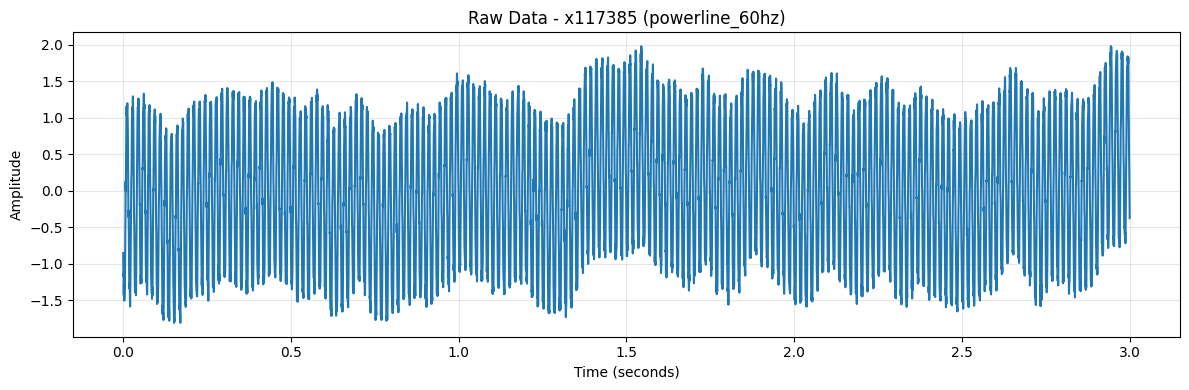


PDM Statistics (after clipping):
  Shape: (10, 10000)
  Time range: 0.50s to 2.50s
  Min: 0.001595, Max: 1.390223, Mean: 0.206714
    0-  4 Hz: mean=0.079007, max=0.118295
    4-  8 Hz: mean=0.146535, max=0.245819
    8- 13 Hz: mean=0.055207, max=0.120614
   13- 30 Hz: mean=0.034269, max=0.116184
   30- 55 Hz: mean=0.153610, max=0.228620
   57- 63 Hz: mean=1.359800, max=1.390223
   65- 80 Hz: mean=0.026486, max=0.146510
   80-150 Hz: mean=0.029240, max=0.139321
  150-250 Hz: mean=0.083304, max=0.156864
  250-500 Hz: mean=0.099680, max=0.156300


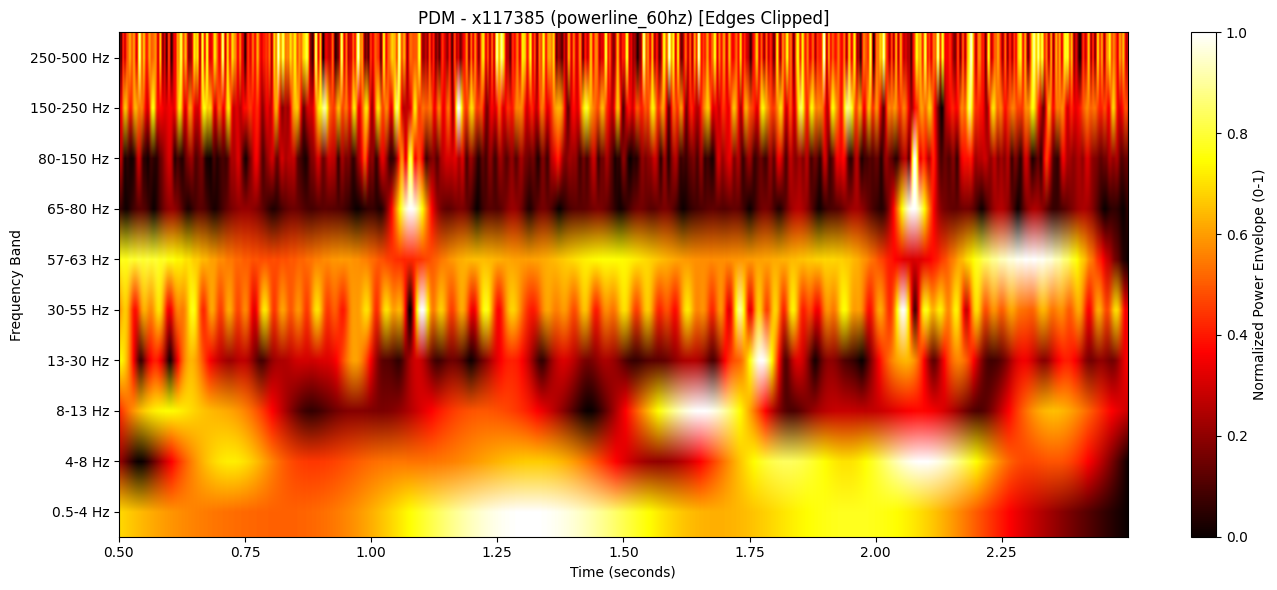

Executing pipeline...
Agent result: powerline noise

Processing 7/10: x114900
Ground truth: powerline_60hz


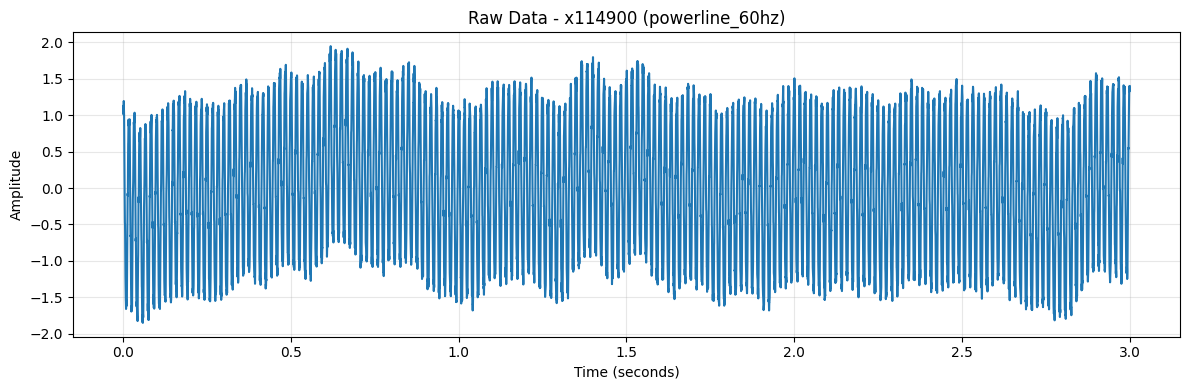


PDM Statistics (after clipping):
  Shape: (10, 10000)
  Time range: 0.50s to 2.50s
  Min: 0.001478, Max: 1.385891, Mean: 0.198813
    0-  4 Hz: mean=0.051236, max=0.125136
    4-  8 Hz: mean=0.126209, max=0.274869
    8- 13 Hz: mean=0.029034, max=0.070924
   13- 30 Hz: mean=0.034070, max=0.093375
   30- 55 Hz: mean=0.153006, max=0.201394
   57- 63 Hz: mean=1.367031, max=1.385891
   65- 80 Hz: mean=0.026403, max=0.142856
   80-150 Hz: mean=0.026942, max=0.136091
  150-250 Hz: mean=0.082621, max=0.136929
  250-500 Hz: mean=0.091577, max=0.165095


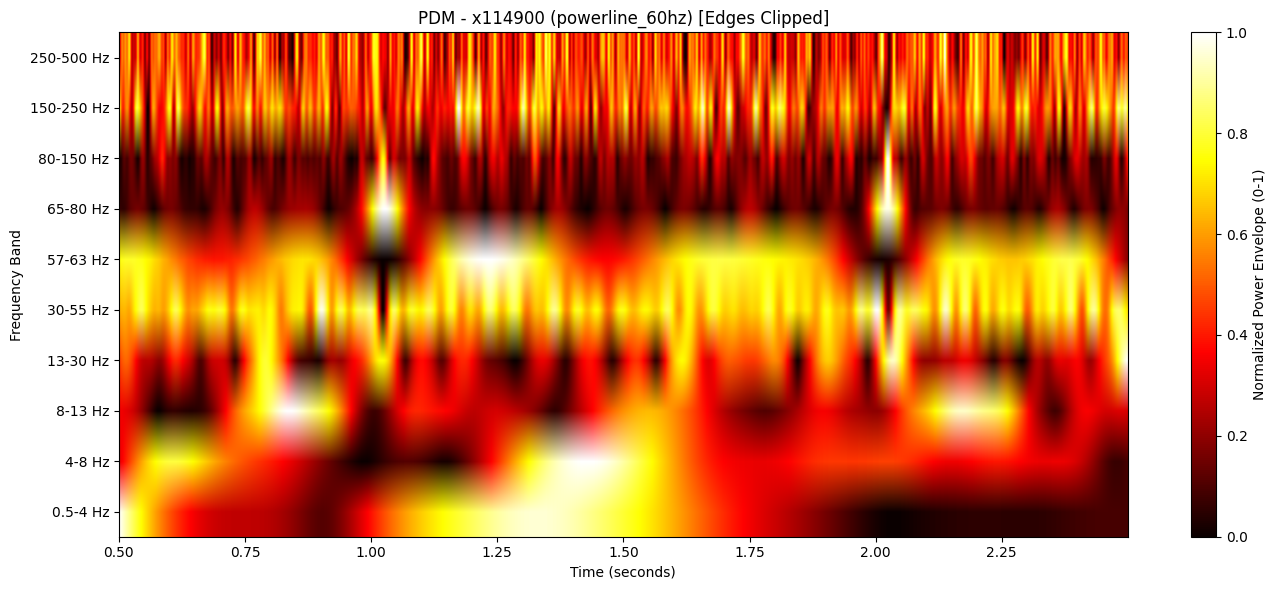

Executing pipeline...
Agent result: powerline noise

Processing 8/10: x115012
Ground truth: powerline_60hz


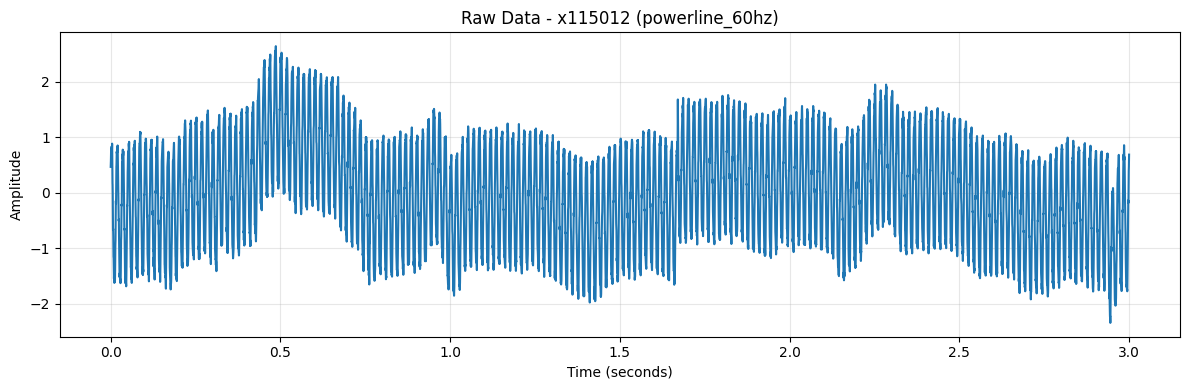


PDM Statistics (after clipping):
  Shape: (10, 10000)
  Time range: 0.50s to 2.50s
  Min: 0.000638, Max: 1.277160, Mean: 0.200990
    0-  4 Hz: mean=0.130125, max=0.187044
    4-  8 Hz: mean=0.144765, max=0.282675
    8- 13 Hz: mean=0.067978, max=0.223100
   13- 30 Hz: mean=0.043044, max=0.166152
   30- 55 Hz: mean=0.140274, max=0.271267
   57- 63 Hz: mean=1.257499, max=1.277160
   65- 80 Hz: mean=0.025217, max=0.155870
   80-150 Hz: mean=0.026491, max=0.183599
  150-250 Hz: mean=0.084487, max=0.194046
  250-500 Hz: mean=0.090023, max=0.193964


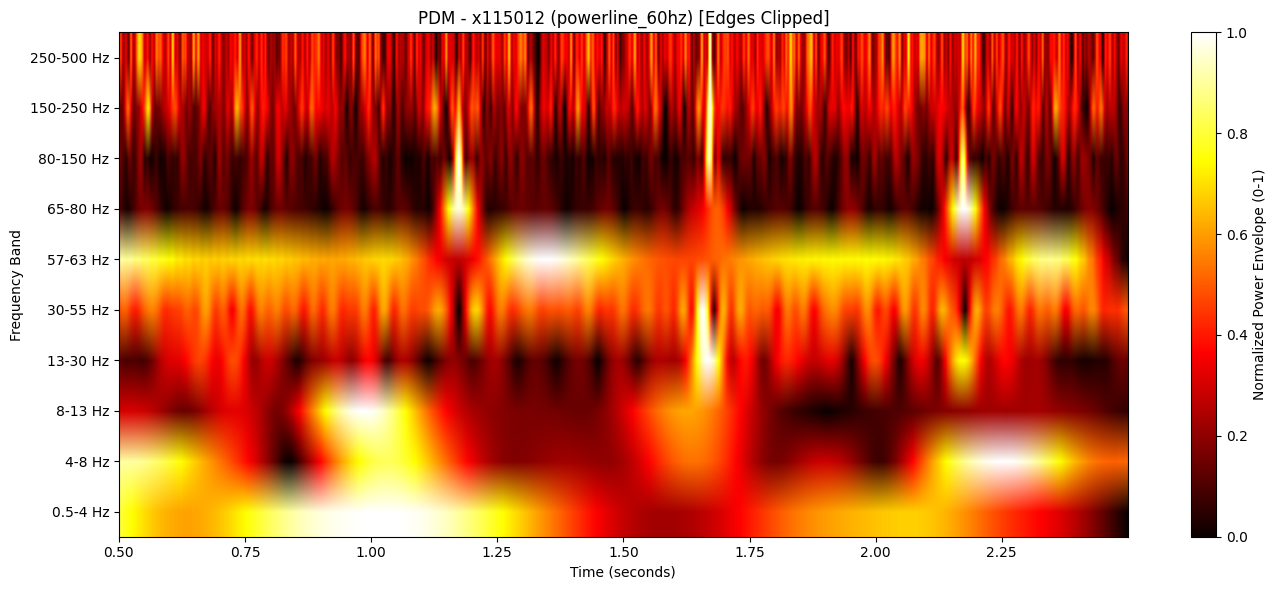

Executing pipeline...
Agent result: powerline noise

Processing 9/10: x076903
Ground truth: powerline_60hz


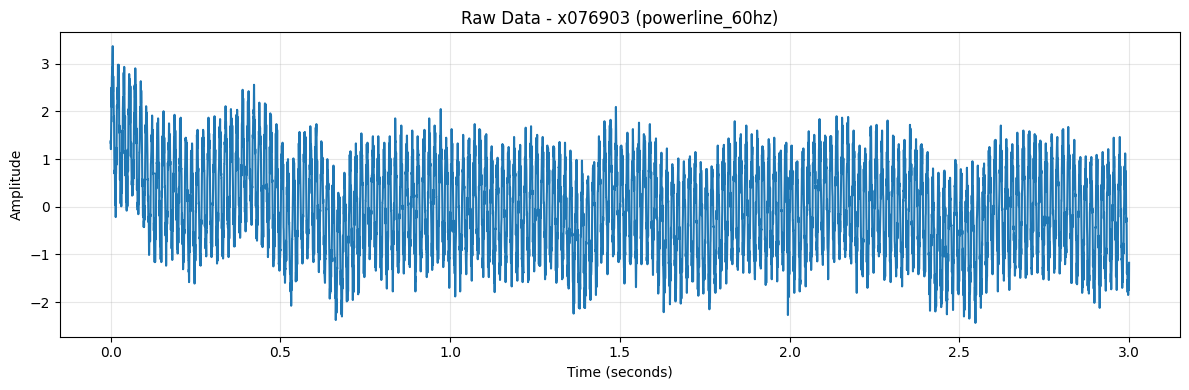


PDM Statistics (after clipping):
  Shape: (10, 10000)
  Time range: 0.50s to 2.50s
  Min: 0.003718, Max: 1.253691, Mean: 0.224858
    0-  4 Hz: mean=0.172294, max=0.330110
    4-  8 Hz: mean=0.182792, max=0.560677
    8- 13 Hz: mean=0.116382, max=0.215017
   13- 30 Hz: mean=0.052525, max=0.175180
   30- 55 Hz: mean=0.138034, max=0.259896
   57- 63 Hz: mean=1.226252, max=1.253691
   65- 80 Hz: mean=0.033051, max=0.075829
   80-150 Hz: mean=0.085564, max=0.212461
  150-250 Hz: mean=0.097909, max=0.272122
  250-500 Hz: mean=0.143775, max=0.329638


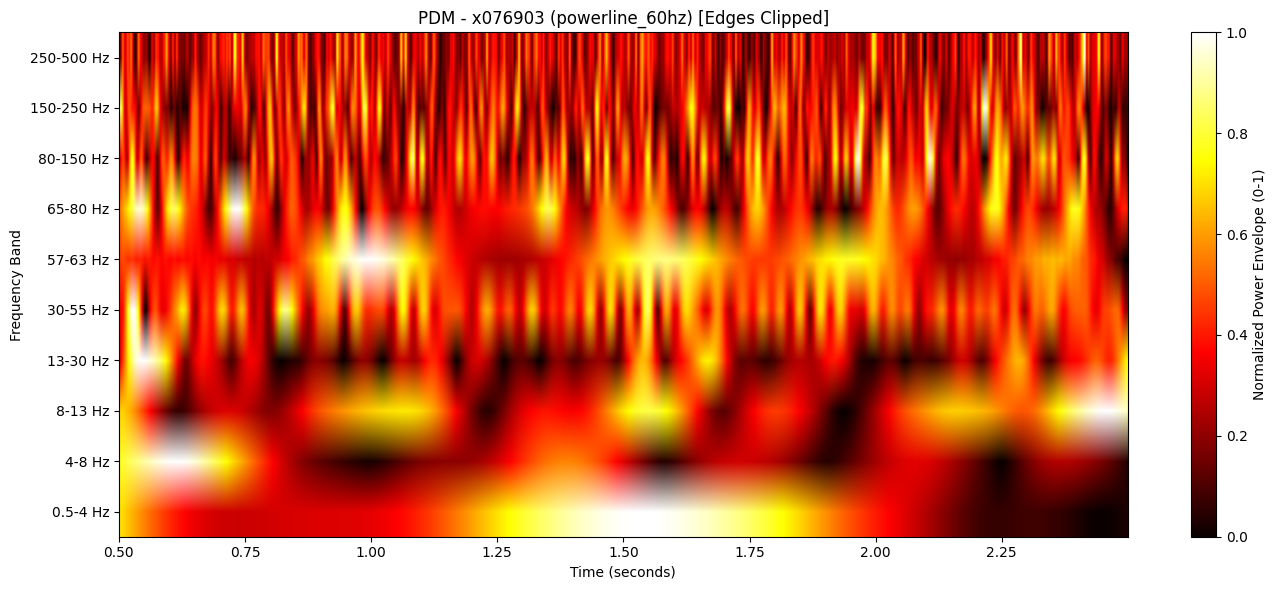

Executing pipeline...
Agent result: powerline noise

Processing 10/10: x079212
Ground truth: powerline_60hz


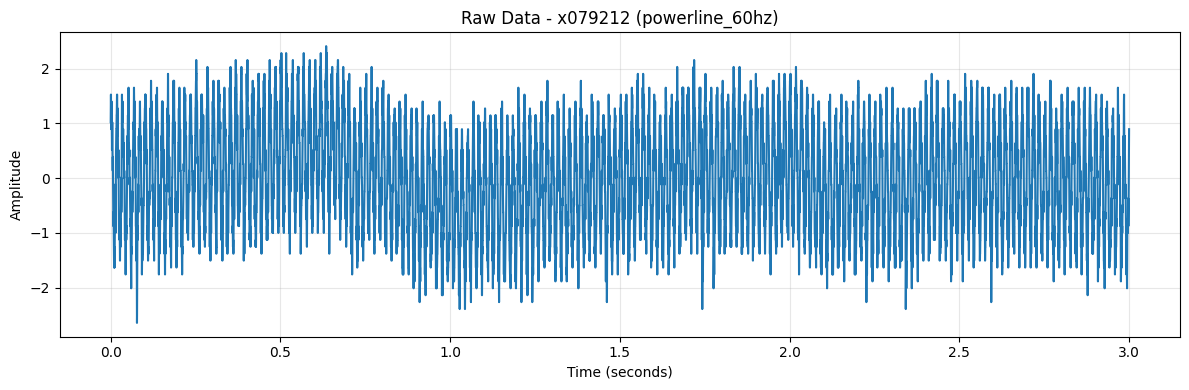


PDM Statistics (after clipping):
  Shape: (10, 10000)
  Time range: 0.50s to 2.50s
  Min: 0.001544, Max: 1.323615, Mean: 0.220832
    0-  4 Hz: mean=0.049246, max=0.126211
    4-  8 Hz: mean=0.125213, max=0.249714
    8- 13 Hz: mean=0.053801, max=0.113899
   13- 30 Hz: mean=0.068439, max=0.151160
   30- 55 Hz: mean=0.152404, max=0.266579
   57- 63 Hz: mean=1.301922, max=1.323615
   65- 80 Hz: mean=0.037540, max=0.081643
   80-150 Hz: mean=0.091932, max=0.228720
  150-250 Hz: mean=0.116370, max=0.295965
  250-500 Hz: mean=0.211449, max=0.437035


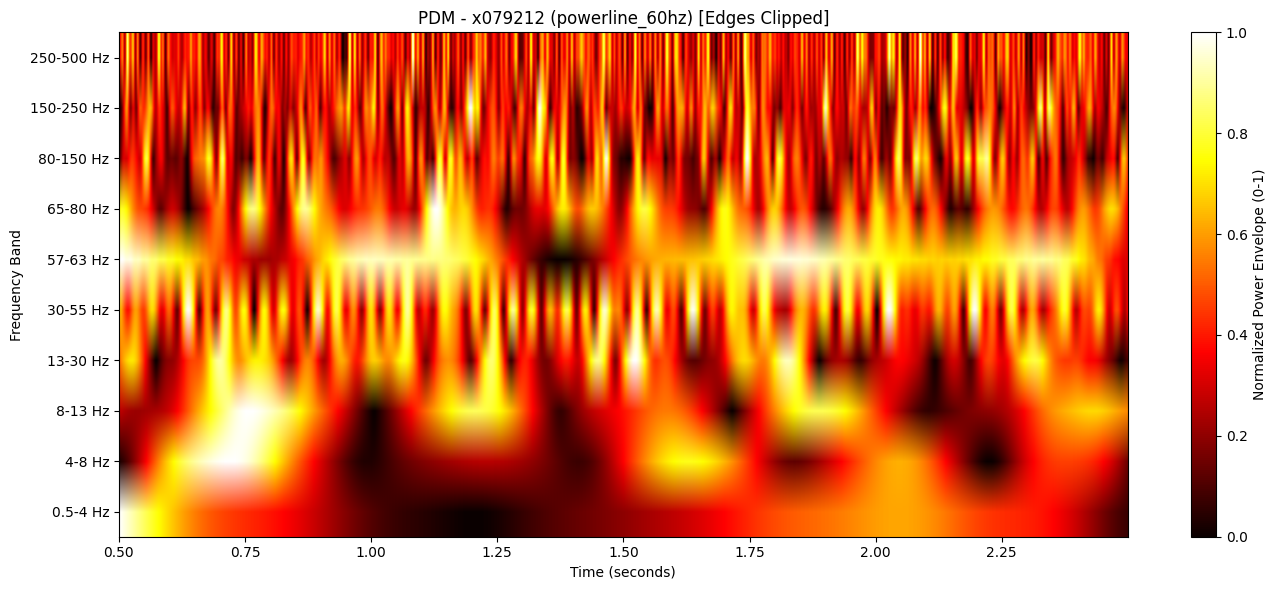

Executing pipeline...
Agent result: powerline noise


In [12]:
if __name__ == "__main__":
    app = build_inspection_graph()

    # select 10 random segments from each category
    test_df = pd.concat([
        # df_noise.sample(10), 
        # df_physiology.sample(10), 
        # df_pathology.sample(10), 
        df_powerline.sample(10)
    ]).reset_index(drop=True)

    # create a result dataframe to store results
    results = []

    for idx, segment_df in test_df.iterrows():
        print(f"\n{'='*60}")
        print(f"Processing {idx+1}/{len(test_df)}: {segment_df['segment_id']}")
        print(f"Ground truth: {segment_df['category_name']}")
        print(f"{'='*60}")
        
        try:
            mat = scipy.io.loadmat(
                "C:\\Users\\yuans\\Desktop\\Mayo_dataset\\DATASET_MAYO\\" + 
                segment_df["segment_id"] + ".mat"
            )
            raw_data = mat["data"].flatten()

            # plot raw data
            plt.figure(figsize=(12, 4))
            time_full = np.arange(len(raw_data)) / 5000
            plt.plot(time_full, raw_data)
            plt.title(f"Raw Data - {segment_df['segment_id']} ({segment_df['category_name']})")
            plt.xlabel("Time (seconds)")
            plt.ylabel("Amplitude")
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()

            # plot PDM
            pdm, pdm_time = compute_pdm_fixed(
                raw_data, fs=5000, freq_bands=freq_bands, clip_seconds=0.5
            )
            plot_pdm_normalized(
                pdm, pdm_time, freq_bands, 
                title=f"PDM - {segment_df['segment_id']} ({segment_df['category_name']}) [Edges Clipped]"
            )
            plt.show()

            metadata = {
                "sampling_rate": 5000,
                "anatomy": segment_df["anatomy"],
                "channel": segment_df["channel"],
                "electrode_type": segment_df["electrode_type"],
                "soz": segment_df["soz"],
                # "suggestions": """for detecting muscle noise, the expert would look at the raw waveform for Look for segments where the 
                # signal shows high-frequency, dense, jagged oscillations that make the trace appear thick, fuzzy, or 'hairy' as if 
                # many rapid up-and-down movements are superimposed on the underlying signal. the expert would also examine the
                # power distribution matrix (PDM) with per-band normalization mode. In the time-frequency representation, muscle artifacts appear as vertical stripes or 
                # bands of bright, high-intensity power spanning broad frequency ranges, especially above 150 Hz. Look for sustained 
                # periods where you see dense, continuous high-frequency activity creating a 'curtain-like' pattern of vertical lines, 
                # rather than the discrete, frequency-specific patterns typical of neural oscillations. These contaminated segments show 
                # elevated power across multiple high-frequency bands simultaneously.
                # for detecting pathology, the expert would look at the power distribution matrix (PDM) with global normalization mode.
                # if there exist a single sharp vertical stripe of high power in a narrow frequency band. which is different from muscle noise which could consist
                # of multiple """,
                "context": """Each data segment is described by clinical useful features: classification category 
                (power line interference; high frequency noise; pathological activity; physiological activity), 
                seizure onset zone (True, False), anatomical location, electrode type, reviewer identification number, patient number.
                In general, datasets contain data clips from four groups of distinctive events: 
                powerline noise (in our case 50 Hz or 60 Hz depending on power line frequency at clinic’s location); 
                muscle and machine artifacts (artifactual signals (like muscle artifacts) caused by patient movement or other physiological sources commonly 
                share features with pathological signals, e.g. power in band 200–600 Hz.); 
                physiological iEEG activity in different behavioral states of subject (sleep/wake/wake-relax); 
                pathophysiological activity we are targeting identification of signal graphoelements and 
                thus defining pathological signal group as signals with epileptiform graphoelements e.g.: HFOs and spikes or epileptiform discharges.
                Mayo Clinic data were recorded during the first night after electrode implantation and consisted of two-hour long iEEG recordings. 
                The data were collected between 1 AM and 3 AM from 25 patients with DRE undergoing evaluation for epilepsy surgery. 
                The Neuralynx Cheetah system (Neuralynx Inc., Bozeman MT, USA) was used to acquire the data at sampling rate of 32 kHz with 
                hardware filter bandwidth of DC – 9 kHz. Similar to St’ Anne’s recordings, all data were filtered by an antialiasing filter, 
                but in this case with cutoff frequency of 1 kHz. The data was subsequently down-sampled to 5 kHz. 
                Patients were implanted with either depth electrodes or grids and strips, or the combination. 
                The depth electrodes used in the dataset were AD-Tech electrodes (AD-Tech Medical Instrument Corp., Racine, WI or PMT, Chahassen, MN, USA) 
                and consisted of 4 or 8 Platinum/Iridium contacts (2.3 mm long, 1 mm diameter, spaced 5 or 10 mm center-to-center). 
                AD-Tech subdural grids and strips electrodes had 4.0 mm diameter Platinum/Iridium discs (2.3 mm exposed) with 10 mm center-to-center distance.
                All data were reviewed in SignalPlant18, a free software tool for signal processing, inspection and annotation. 
                The dataset was annotated by 3 reviewers, where each recording was reviewed by single reviewer. 
                Each recording was visually reviewed in time domain alongside power distribution matrices (PDM) for manual artifact detection13. 
                The PDM method estimates the signal power envelope by data filtering in specific frequency bands, 
                and further computes the absolute value of the analytical signal (analytical signal is complex signal comprising original signal in the real domain 
                and its Hilbert transform in imaginary domain) to obtain the signal envelope. Visual inspection of the PDM allow for fast localization of high-power 
                events appearing across all channels and are likely to be artifacts. The signal regions with high power envelope were subsequently reviewed in the 
                time domain to classify signals into pathological/artifactual group."""
            }

            init_state: InspectionState = {
                "goal": "determine which one of the four category (artifact, physiology, pathology, powerline noise)the segment is best described by.",
                "raw_data": raw_data,
                "metadata": metadata,
                "max_steps": 3,
                "step": 0,
                "example_bank": bank,
            }

            def extract_result_safely(result):
                """Extract category, confidence, and rationale from result, handling various formats"""
                try:
                    goal_output = result["goal_output"]
                    
                    # Convert Pydantic models to dict
                    def to_dict(obj):
                        if hasattr(obj, "model_dump"):
                            return obj.model_dump()
                        elif hasattr(obj, "dict"):
                            return obj.dict()
                        elif isinstance(obj, dict):
                            return obj
                        else:
                            return dict(obj)
                    
                    goal_output_dict = to_dict(goal_output)
                    
                    # Handle nested goal_output
                    if "goal_output" in goal_output_dict:
                        result_data = goal_output_dict["goal_output"]["result"]
                    else:
                        result_data = goal_output_dict["result"]
                    
                    return {
                        "category": result_data["category"],
                    }
                
                except Exception as e:
                    print(f"\nDEBUG - Error extracting result:")
                    print(f"  Error: {e}")
                    print(f"  Result keys: {result.keys()}")
                    print(f"  Goal output type: {type(result.get('goal_output'))}")
                    if 'goal_output' in result:
                        print(f"  Goal output: {result['goal_output']}")
                    raise

            print("Executing pipeline...")
            result = app.invoke(init_state)
            extracted = extract_result_safely(result)

            agent_result = extracted["category"]

            print(f"Agent result: {agent_result}")
            
            # Store results
            results.append({
                "segment_id": segment_df["segment_id"],
                "agent_result": agent_result,
                "ground_truth": segment_df["category_name"]
            })
            
        except Exception as e:
            print(f"ERROR processing {segment_df['segment_id']}: {e}")
            results.append({
                "segment_id": segment_df["segment_id"],
                "agent_result": "ERROR",
                "ground_truth": segment_df["category_name"]
            })
            continue

    # Create results dataframe
    result_df = pd.DataFrame(results)
    
    # Remove any error rows for accuracy calculation
    result_df_clean = result_df[result_df["agent_result"] != "ERROR"]
    
    # save result_df to csv
    result_df.to_csv("agent_inspection_results_withoutsuggestions_powerline.csv", index=False)

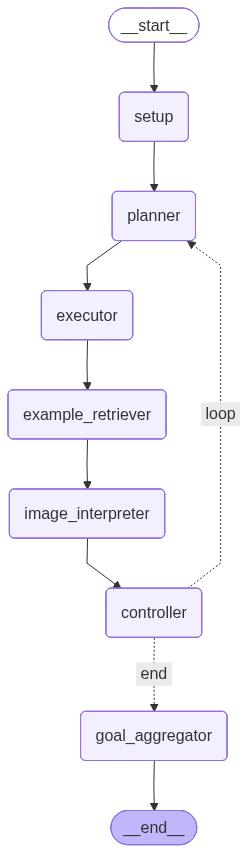

In [ ]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Failed to display graph: {str(e)}")

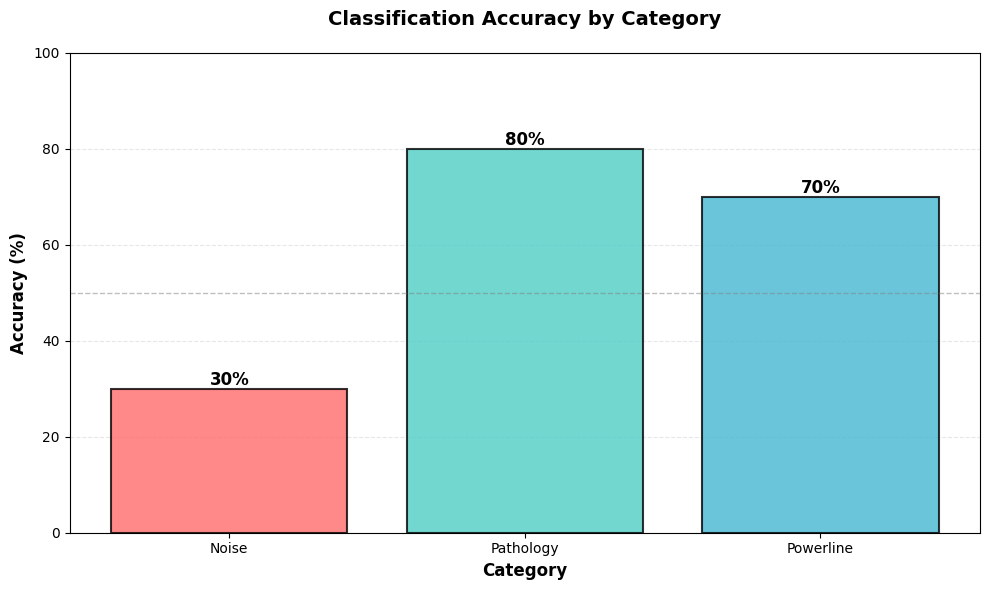

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Data
categories = ['Noise', 'Pathology', 'Powerline']
accuracies = [30, 80, 70]

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create bar plot
bars = ax.bar(categories, accuracies, color=['#FF6B6B', '#4ECDC4', '#45B7D1'], 
              edgecolor='black', linewidth=1.5, alpha=0.8)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height}%',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

# Customize plot
ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax.set_xlabel('Category', fontsize=12, fontweight='bold')
ax.set_title('Classification Accuracy by Category', fontsize=14, fontweight='bold', pad=20)
ax.set_ylim(0, 100)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Add horizontal line at 50% for reference
ax.axhline(y=50, color='gray', linestyle='--', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.show()